In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

plt.rcParams["figure.figsize"] = (12, 9)

In [2]:
def perp(vector): # rotates a vector 90 degrees counter clock-wise
    return np.array([- vector[1], vector[0], 0.])

def int_x(origin, direction): # finds the intersection point between a line and a the x-axis
    x = origin[0] - ( origin[1] / direction[1] ) * direction[0]
    return np.array([x, 0., 1.]) 

def int_y(origin, direction): # finds the intersection point between a line and the y-axis
    y = origin[1] - ( origin[0] / direction[0] ) * direction[1]
    return np.array([0., y, 1.])

def line_int_0(line): # finds the intersection point between a line and the x-axis
    return np.array([- line[2] / line[0], 0., 1.])

def line_int_1(line): # finds the intersection point between a line and a the y-axis
    return np.array([0., - line[2] / line[1], 1.])

def intersect(origin, direction):
    x = origin[0] - ( origin[1] / direction[1] ) * direction[0]
    y = origin[1] - ( origin[0] / direction[0] ) * direction[1]
    return np.array([[x, 0., 1.], [0., y, 1.]])

def make_line_array(point, direction, interval, number_of_nodes):
    u_dir = direction / np.linalg.norm(direction)
    ds = np.linspace(interval[0], interval[1], number_of_nodes)
    ds = ds[:,np.newaxis]
    line_array = point[np.newaxis,:] + ds.dot(u_dir[np.newaxis,:])
    return line_array

def matrix_from_weights(weights, bias):
    W = np.hstack((weights, bias[:, np.newaxis]))
    W = np.vstack((W, np.array([0,0,1])))
    return W

def organize_input(weights, bias, final_layer=True):
    n = len(weights)-1
    W = []
    for i in range(n):
        W.append(matrix_from_weights(weights[i], bias[i]))
    if final_layer:
        W.append(np.array([ weights[n][0],  weights[n][1],  bias[n][0]]))
    return W

In [3]:
class polyline:
    def __init__(self):
        self.points = np.array([])
    def initialize(self, line):
        e_x = np.array([1,  0., 0.])
        e_y = np.array([0., 1., 0.])
        O   = np.array([0., 0., 1.])
        if abs(line[1]) < 1e-12: # vertical line
            X = line_int_x(line)
            if X[0] >= 0.:
                self.points = np.array([-e_y, X,  e_y])
            else: 
                self.points = np.array([-e_y, O, -e_x])
        elif abs(line[0]) < 1e-12: # line is horizontal
            Y = line_int_y(line)
            if Y[1] >= 0.:
                self.points = np.array([ e_x, Y, -e_x])
            else: 
                self.points = np.array([-e_y, O, -e_x])
        else: # line is in general position
            X = line_int_0(line)
            Y = line_int_1(line)
            if X[0] >= 0. and Y[1] >= 0.:
                self.points = np.array([-e_y, X, Y, -e_x])
            elif X[0] >= 0. and Y[1] < 0.:
                v =  np.array([line[1], -line[0], 0.])
                v = np.sign(v[0]) * v
                self.points = np.array([-e_y, X, v])
            elif X[0] < 0. and Y[1] >= 0.:
                v =  np.array([line[1], -line[0], 0.])
                v = np.sign(v[0]) * v
                self.points = np.array([ v, Y, -e_x])
            else:
                self.points = np.array([-e_y, O, -e_x])
            return None
    def print_out(self):
        print(self.points)
        return None
    def clone(self):
        new = polyline()
        new.points = self.points.copy()
        return None
    def push_forward(self, W):
        self.points = self.points.dot(W.T)
        return None
    def pull_back(self, W):
        self.points = self.points.dot(np.linalg.inv(W).T)
        return None
    def crop(self):
        e_x = np.array([1,  0., 0.])
        e_y = np.array([0., 1., 0.])
        n_points = self.points.shape[0]
        res = []
        for i in range(n_points-1):
            p_0 = self.points[i,:]
            p_1 = self.points[i+1,:]
            if abs(p_0[2]-1.) < 1e-12 and abs(p_1[2]-1.) < 1e-12: # both are finite points!
                if p_0[0] >= 0. and p_0[1] >= 0.: # p_0 is in quadrant 1
                    if p_1[0] >= 0. and p_1[1] >= 0.: # p_1 is also in pquadrant 
                        res.append(p_1)
                    else: # p_1 is outside quadrant 1
                        v = p_1-p_0
                        if perp(p_0).dot(v) <= 0.: 
                            X = int_x(p_0, v)
                            res.extend([X, -e_y])
                        else:
                            Y = int_y(p_0, v)
                            res.extend([Y, -e_x])
                elif p_1[0] >= 0. and p_1[1] >= 0.: # p_1 is in quadrant 1, but p_0 is not!
                    v_ = p_0 - p_1 
                    if perp(p_1).dot(v_) <= 0.: 
                        X = int_x(p_1, v_)
                        res.extend([-e_y, X, p_1])
                    else:
                        Y = int_y(p_1, v_)
                        res.extend([-e_x, Y, p_1])
                else: # both p_0 and p_1 are outside the positive sector
                    # check if tere are two intersection points or none!
                    if p_0[0] > 0. and p_1[1] > 0.: # p_0 in quadrant 4, p_1 in quadrant 2
                        intercepts = intersect(p_0,  p_1 - p_0)                        
                        if np.all(intercepts >= 0.):
                            res.extend([-e_y, intercepts[0,:], intercepts[1,:], -e_x])
                    elif p_0[1] > 0. and p_1[0] > 0.: # p_0 in quadrant 2, p_1 in quadrant 4
                        intercepts = intersect(p_0,  p_1 - p_0) 
                        if np.all(intercepts >= 0.):
                            res.extend([-e_x, intercepts[1,:], intercepts[0,:], -e_y])                            
            elif abs(p_0[2]-1.) < 1e-12 and abs(p_1[2]) < 1e-12: # p_0 is a finite point, but p_1 is a direction!
                if p_0[0] >= 0. and p_0[1] >= 0.: # p_0 is in quadrant 1
                    if p_1[0] >= 0. and p_1[1] >= 0.: # vector p_1 points inside quadrant 1    
                        res.append(p_1)
                    elif perp(p_0).dot(p_1) <= 0.: 
                        X = int_x(p_0, p_1)
                        res.extend([X, -e_y])
                    else:
                        Y = int_y(p_0, p_1) 
                        res.extend([Y, -e_x]) 
                elif p_0[0] < 0. and p_0[1] >= 0. and p_1[0] >= 0. and perp(p_0).dot(p_1) <= 0.: # p_0 in quadratn 2
                    Y = int_y(p_0, p_1)
                    res.extend([-e_x, Y, p_1])
                elif p_0[0] >= 0. and p_0[1] < 0. and p_1[1] >= 0. and perp(p_0).dot(p_1) >= 0.: # p_0 in quadrant 4
                    X = int_x(p_0, p_1)
                    res.extend([-e_y, X, p_1])
                elif p_0[0] < 0. and p_0[1] < 0.: # p_0 in quadrant 3
                    if p_0[0] >= 0. and perp(p_1).dot(p_0) <= 0.:
                        Y = int_y(p_0, p_1)
                        res.extend([-e_x, Y, p_1])
                    elif p_0[1] >= 0. and perp(p_1).dot(p_0) >= 0.:
                        X = int_x(p_0, p_1)
                        res.extend([-e_y, X, p_1])                    
            elif abs(p_0[2]) < 1e-12 and abs(p_1[2]-1) < 1e-12: # p_1 is a finite point, but p_0 is a direction!
                if p_1[0] >= 0. and p_1[1] >= 0.:# p_1 is in quadrant 1
                    if p_0[0] >= 0. and p_0[1] >= 0.: # p_0 points in quadrant 1
                        res.extend([p_0, p_1])                        
                    elif perp(p_1).dot(p_0) <= 0.: 
                        X = int_x(p_1, p_0)
                        res.extend([-e_y, X, p_1])
                    else:
                        Y = int_y(p_1, p_0)
                        res.extend([-e_x, Y, p_1])                        
                elif p_1[0] < 0. and p_1[1] >= 0. and p_0[0] >= 0. and perp(p_1).dot(p_0) <= 0.: # p_1 in quadrant 2
                    Y = int_y(p_1, p_0)
                    res.extend([p_0, Y, -e_x])
                elif p_1[0] >= 0. and p_1[1] < 0. and p_0[1] >= 0. and perp(p_1).dot(p_0) >= 0.: # p_1 in quadrant 4
                    X = int_x(p_1, p_0)
                    res.extend([p_0, X, -e_y])
                elif p_1[0] < 0. and p_1[1] < 0.: # p_1 in squadrant 3
                    if p_0[0] >= 0. and perp(p_1).dot(p_0) <= 0.:
                        Y = int_y(p_1, p_0)
                        res.extend([p_0, Y, -e_x])
                    elif p_0[1] >= 0. and perp(p_1).dot(p_0) >= 0.:
                        X = int_x(p_1, p_0)
                        res.extend([p_0, X, -e_y])                        
        if len(res) == 0.:
            res = [-e_y , [0.,0.,1.], e_x]
        self.points = np.array(res)
        return None    
    def plot(self, axs, length_of_ends):
        points = self.points.copy()
        n_points = points.shape[0]
        points[0,:] = points[1,:] + length_of_ends*points[0,:] / np.linalg.norm(points[0,:])
        points[n_points-1,:] = points[n_points-2,:] + length_of_ends*points[n_points-1,:] / np.linalg.norm(points[n_points-1,:])
        #fig, axs = plt.subplots(1,1)
        axs.set_aspect('equal')
        axs.plot(points[:,0], points[:,1], 'r')
        for point in points:
            axs.plot(point[0], point[1], 'bo')
        return None

In [4]:
class axis:
    
    def __init__(self, horizontal_or_vertical):
        
        if horizontal_or_vertical == 0:
            v = np.array([1., 0., 0.])
            a = np.array([[-1., 0., 1.], [0.,0.,1.], [1., 0., 1.]])
        else:
            v = np.array([0., 1., 0.])
            a = np.array([[ 0.,1.,1.], [0.,0.,1.], [ 0.,1.,1.]])
            
        self.origin = np.array([0.,0.,1])
        self.i_o = 1
        self.direction = v
        self.array = a
        self.dotted = np.array([True, False, False])
        self.i_dotted = np.array([0, 1])
        self.solid = np.array([False, True, True])
        self.i_solid = np.array([1, 3])
        
        return None 
    
    def subdiv(self, interval, number_of_points):
        a = np.linspace(interval[0], interval[1], number_of_points)
        e =  np.ones( a.size,  dtype=float )
        o = np.zeros( a.size,  dtype=float ) 
        self.dotted = a < 0.      
        self.i_dotted = np.where(a < 0.)[0]
        self.i_dotted  = [self.i_dotted[0], self.i_dotted[-1]+1]
        self.solid = a >= 0.  
        self.i_solid = np.where(a >= 0.)[0]
        self.i_solid  = [self.i_solid[0], self.i_solid[-1]+1]
        self.i_o = np.where(self.solid)[0][0]
        if abs(self.direction[1]) < 1e-12:
            a = np.array([a, o, e]).T
        else:
            a = np.array([o, a, e]).T
        self.array = a
        return None
    
    def get_origin(self):
        return self.origin
    def get_i_o(self):
        return self.i_o
    def get_points(self):
        return self.array
    def get_direction(self):
        return self.direction
    
    def clone(self, horizontal_or_vertical=0):
        new = axis(horizontal_or_vertical)
        new.origin = self.origin.copy()
        new.i_o= self.i_o
        new.direction = self.direction.copy() 
        new.array = self.array.copy()               
        new.dotted = self.dotted.copy()
        new.i_dotted = self.i_dotted.copy()
        new.solid = self.solid.copy()
        new.i_solid = self.i_solid.copy()
        return new
    
    def push_forward(self, W):
        W_T = W.T
        self.origin = self.origin.dot(W_T)
        self.direction = self.direction.dot(W_T) 
        self.array = self.array.dot(W_T)
        return None
    
    def pull_back(self, W):
        W_T_ = np.linalg.inv(W).T
        self.origin = self.origin.dot(W_T_)
        self.direction = self.direction.dot(W_T_) 
        self.array = self.array.dot(W_T_)
        return None
    
    def crop(self): 
        if np.any(self.solid): # or maybe len(self.i_solid) > 0
        # if nothing solid is visible then we are in a situation o---, leave it as is
        # else if something solid is visible, cropping is needed:
            in_sector = np.logical_and(self.array[:,0] >= 0.,  self.array[:,1] >= 0.) 
            if self.origin[0] <= 0. or self.origin[1] <= 0.: 
            # origin is outside positive sector  
                self.solid = np.logical_and(self.solid, in_sector)
                if np.any(self.solid): 
                    # if there is still something solid left after cropping, 
                    # readjust self.solid and self.dotted
                    self.i_solid = np.where(self.solid)[0]
                    self.i_solid = [self.i_solid[0], self.i_solid[-1]+1]
                    self.i_dotted = [self.i_o, self.i_solid[0]]
                    self.solid = np.full(self.array.shape[0], False)
                    self.solid[ self.i_solid[0] : self.i_solid[1] ] = True
                    self.dotted = np.full(self.array.shape[0], False)
                    self.dotted[ self.i_dotted[0] : self.i_dotted[1] ] = True
                else: 
                    # if there is nothing solid left
                    self.i_solid = []
                    self.i_dotted = [self.i_o, self.array.shape[0]]
                    self.dotted = np.full(self.array.shape[0], False)
                    self.dotted[ self.i_dotted[0] : self.i_dotted[1] ] = True 
            else: 
            # origin is inside the positive sector
                self.solid = np.logical_and(self.solid, in_sector)
                self.dotted = np.logical_and(self.dotted, in_sector)
                self.i_solid = np.where(self.solid)[0]
                self.i_solid = [self.i_solid[0], self.i_solid[-1]+1]
                self.i_dotted = np.where(self.dotted)[0]
                if len(self.i_dotted) != 0:
                    self.i_dotted = [self.i_dotted[0], self.i_dotted[-1]+1]
                else: 
                    self.i_dotted = []
        return None
    
    def plot(self, axs, layer_color, frame_shape, plot_origin=True, only_solid=False):
        width = frame_shape[0] # an interval along the horizontal axis
        height  = frame_shape[1] # an interval along the vertical axis
        visible = np.logical_and(width[0] <= self.array[:,0], self.array[:,0] <= width[1])
        visible = np.logical_and(height[0] <= self.array[:,1], visible)
        visible = np.logical_and(visible, self.array[:,1] <= height[1])
        if np.any(self.dotted) and not only_solid:
            dotted_visible = np.logical_and(self.dotted, visible)
            if np.any(dotted_visible):
                axs.plot(self.array[ dotted_visible, 0], self.array[ dotted_visible, 1], layer_color+'--')
        if np.any(self.solid):
            solid_visible = np.logical_and(self.solid, visible)
            if np.any(solid_visible):
                axs.plot(self.array[ solid_visible, 0], self.array[ solid_visible, 1], layer_color)
        if plot_origin:
            axs.plot(self.origin[0], self.origin[1], layer_color+'o')
        return None
    
    def build_from_line(self, line, length_and_n_points):
        interval = length_and_n_points[0]
        number_of_points = length_and_n_points[1]
        v = np.array([line[1], -line[0], 0.])
        if abs(v[0]) > 1e-10:
            self.origin = line_int_1(line)
            self.origin[1] = abs(self.origin[1]) 
            self.direction = np.sign(v[0]) * v
            self.array = make_line_array(self.origin, self.direction, interval, number_of_points)
            self.dotted = self.array[:,0] < 0. 
            self.i_dotted = np.where(self.dotted)[0]
            self.i_dotted = [self.i_dotted[0], self.i_dotted[-1]]
            self.solid = np.logical_not(self.dotted)
            self.i_solid = np.where(self.solid)[0]
            self.i_solid = [self.i_solid[0], self.i_solid[-1]]
            self.i_o = self.i_solid[0]
        else:
            self.origin = line_int_0(line)
            self.origin[0] = abs(self.origin[0]) 
            self.direction = np.sign(v[1]) * v
            self.array = make_line_array(self.origin, self.direction, interval, number_of_points)
            self.dotted = self.array[:,1] < 0. 
            self.i_dotted = np.where(self.dotted)[0]
            self.i_dotted = [self.i_dotted[0], self.i_dotted[-1]]
            self.solid = np.logical_not(self.dotted)
            self.i_solid = np.where(self.solid)[0]
            self.i_solid = [self.i_solid[0], self.i_solid[-1]]
            self.i_o = self.i_solid[0]
        return None

In [5]:
class sector:
    def __init__(self):
        self.axis_0 = axis(0)
        self.axis_1 = axis(1)
        return None
    def subdiv(self, width, height):
        self.axis_0.subdiv(width[0], width[1])
        self.axis_1.subdiv(height[0], height[1])
        return None
    def clone(self):
        new = sector()
        new.axis_0 = self.axis_0.clone()
        new.axis_1 = self.axis_1.clone()
        return new
    def get_origin(self):
        return self.axis_0.get_origin()
    def get_directions(self):
        return np.array([self.axis_0.direction, self.axis_1.direction])
    def pull_back(self, W):
        self.axis_0.pull_back(W)
        self.axis_1.pull_back(W)
        return None
    def push_forward(self, W):
        self.axis_0.push_forward(W)
        self.axis_1.push_forward(W)
        return None
    def crop(self):
        self.axis_0.crop() 
        self.axis_1.crop() 
        return None
    def plot(self,  axs,  layer_colors,  frame_shape,
                   plot_origin=True, only_solid_0=False, only_solid_1=False):
        if type(layer_colors) == list:
            self.axis_0.plot(axs, layer_colors[0], frame_shape, plot_origin, only_solid_0)
            self.axis_1.plot(axs, layer_colors[1], frame_shape, plot_origin, only_solid_1)
        elif type(layer_colors) == str:
            self.axis_0.plot(axs, layer_colors, frame_shape, plot_origin, only_solid_0)
            self.axis_1.plot(axs, layer_colors, frame_shape, plot_origin, only_solid_1)
        return None


In [6]:
def draw_sectors(axs,   matrix_list,   colors_list,   width_list,  height_list,  frame_shape,  remove_dotted_list): 
    n_layers = len(matrix_list)
    a = axis(0)
    a.build_from_line(matrix_list[n_layers-1], width_list[n_layers-1])
    print(len(np.where(a.dotted)[0]))
    print(a.origin)
    #return None
    a.crop()
    print(len(np.where(a.dotted)[0]))
    #return None
    layers_list = [a]
    for i in range(n_layers-2, -1, -1):
        layer = sector()
        layer.subdiv(width_list[i], height_list[i])
        layers_list.append(layer)
        for j in range(len(layers_list)):
            layers_list[j].pull_back(matrix_list[i])
            if i > 0:
                layers_list[j].crop()
    axs.set_aspect('equal')
    n_i = n_layers - 1
    if remove_dotted_list[n_layers-1]: #only_solid_list[n_layers-1]:
        layers_list[0].plot(axs, colors_list[n_i], frame_shape, plot_origin=False, only_solid=True)
    else:
        layers_list[0].plot(axs, colors_list[n_i], frame_shape) 
    for i in range(1, n_layers):
        n_i = n_layers - i - 1
        if remove_dotted_list[n_i]:
            layers_list[i].plot(axs, colors_list[n_i], frame_shape, plot_origin=False, only_solid_0=True, only_solid_1=True)
        else:
            layers_list[i].plot(axs, colors_list[n_i], frame_shape) 
    return None

In [7]:
def draw_polyline(axs,  matrix_list, length_of_ends, layer_to_plot=0):
    n_layers = len(matrix_list)
    pl = polyline()
    pl.initialize(matrix_list[n_layers-1])
    if layer_to_plot==n_layers-1:
        pl.plot(axs, length_of_ends)
        return None
    for n_i in range(n_layers-2, layer_to_plot, -1):
        pl.pull_back(matrix_list[n_i])
        pl.crop()
    pl.pull_back(matrix_list[layer_to_plot]) 
    if layer_to_plot!=0: # layer 0
        pl.crop()
    pl.plot(axs, length_of_ends)
    return None

In [8]:
W3 = np.array([4, -1, 1])

W2 = np.array([[-1, 1, 1],
               [-8, 0, 9],
               [ 0, 0, 1]])

W2 = np.array([[1,-1, 0], 
               [4, 0, 1], 
               [0, 0, 1]]).dot(np.linalg.inv(W2))

W1 = np.array([[-1, 1,   1 ],
               [ 1, 1,-0.25], 
               [ 0 ,0,   1 ]])

W1 = np.array([[-1, 1, 1], 
               [-8, 0, 9], 
               [ 0, 0, 1]]).dot(np.linalg.inv(W1))
print(W3)
print('')
print(W2)
print('')
print(W1)

W = [W1, W2, W3]

[ 4 -1  1]

[[-1.   0.   1. ]
 [ 0.  -0.5  5.5]
 [ 0.   0.   1. ]]

[[ 1.  0.  0.]
 [ 4. -4.  4.]
 [ 0.  0.  1.]]


2500
[0. 1. 1.]
0


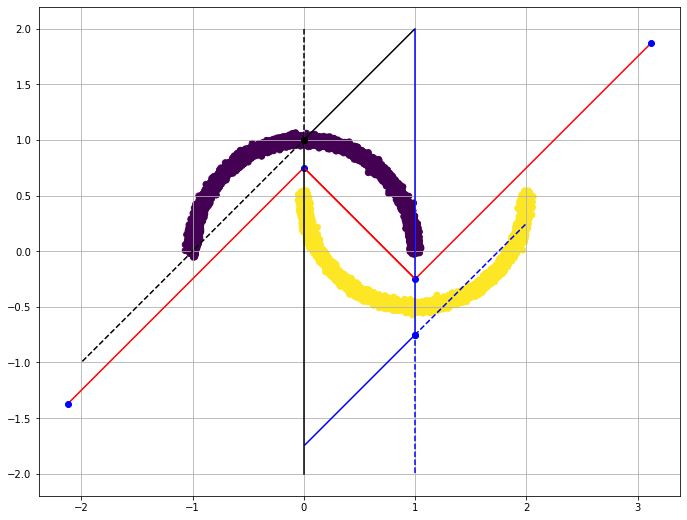

In [9]:
fig, axs = plt.subplots(1,1)
axs.set_aspect('equal')


X,Y = datasets.make_moons(n_samples=20000, shuffle=True, noise=0.02, random_state=1234)
y = np.reshape(Y, (len(Y),1))

axs.scatter(X[:,0], X[:,1], c=Y)

draw_polyline(axs, W, 3, 0)

k = 50
n = 5000
I = [[-k, k], n]

draw_sectors(axs,matrix_list=W,   
                colors_list=['k', 'b', 'r'],   
                width_list=len(W)*[I],  
                height_list=len(W)*[I],  
                frame_shape=[[-2,2],[-2,2]],  
                remove_dotted_list=[False, False, True])



#a, b = 2, 2
#axs.plot([0, a], [0, 0], 'k')
#axs.plot([0, 0], [0, b], 'k')

#axs.plot([0,pl.points[0,0]], [0,pl.points[0,1]], 'r')
#axs.plot(pl.points[0,0], pl.points[0,1], 'bo')

plt.grid()
plt.show()